In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# 랜덤 시드 설정 (항상 동일한 변형이 적용되도록)
np.random.seed(12345)
tf.random.set_seed(12345)

In [4]:
# 사용자 정의 증강 함수 (이미지 5가지 중 하나를 선택하여 적용)
def custom_augmentation(image):
    augmentation_type = np.random.choice(["rotation", "zoom", "shear", "crop", "horizontal_flip"])
    
    if augmentation_type == "rotation":
        # 회전 각도를 무작위로 선택 (45, 90, 135, ..., 315)
        angles = [45, 90, 135, 180, 225, 270, 315]
        angle = np.random.choice(angles)
        image = tf.keras.preprocessing.image.random_rotation(image, angle)
    
    elif augmentation_type == "zoom":
        # 크기 확대/축소
        image = tf.keras.preprocessing.image.random_zoom(image, (0.8, 1.2), fill_mode='nearest')
    
    elif augmentation_type == "shear":
        # 찌그러뜨리기
        image = tf.keras.preprocessing.image.random_shear(image, 0.2, fill_mode='nearest')
    
    elif augmentation_type == "crop":
        # 이미지 크롭
        image = tf.keras.preprocessing.image.random_shift(image, 0.2, 0.2, fill_mode='nearest')
    
    elif augmentation_type == "horizontal_flip":
        # 좌우 반전
        image = tf.image.flip_left_right(image)
    
    return image

In [5]:
# 원본 데이터를 사용한 ImageDataGenerator (변형 없이 사용)
original_datagen = ImageDataGenerator(
    rescale=1.0 / 255  # 정규화만 적용
)  

# 변형된 이미지를 추가하기 위한 ImageDataGenerator
augmented_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=custom_augmentation,  # 사용자 정의 증강 함수 적용
)

# 검증 데이터는 따로 경로에서 불러오되, 배치 단위로 불러오고 정규화하기 위해 생성기 사용
validation_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# 경로에서 데이터를 불러옴
train_data_dir = "data/horse-or-human/train"
validation_data_dir = "data/horse-or-human/validation"
img_size = (224, 224)

In [7]:
# 배치 크기를 32로 설정
batch_size = 32

# 원본 이미지 생성기
original_generator = original_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,  # 원본 데이터 배치 크기 설정
    class_mode='binary'
)

# 변형된 이미지 생성기
augmented_generator = augmented_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,  # 변형된 데이터 배치 크기 설정
    class_mode='binary'
)

# 검증 데이터 생성기 (경로에서 불러오면서 정규화 및 배치 처리)
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [8]:
# VGG16 모델을 처음부터 학습하도록 설정
base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))

In [9]:
# 모델 구성
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))

# 모델 컴파일
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [10]:
# 두 개의 데이터 제너레이터를 합치는 함수 (원본 1027개 + 변형된 1027개)
def combined_generator(original_gen, augmented_gen):
    while True:
        original_data = next(original_gen)
        augmented_data = next(augmented_gen)
        combined_data = np.concatenate([original_data[0], augmented_data[0]], axis=0)
        combined_labels = np.concatenate([original_data[1], augmented_data[1]], axis=0)
        yield combined_data, combined_labels

In [12]:
# 모델 학습 (에포크당 1027개 원본 + 1027개 변형된 데이터로 총 2054개 학습)
# 총 에포크 10개, 배치사이즈 32개
history = model.fit(
    combined_generator(original_generator, augmented_generator),
    steps_per_epoch=len(original_generator),  # 배치 크기에 맞춘 steps_per_epoch
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=10,  # 총 10 에포크 학습
    verbose=1
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 41s/step - accuracy: 0.4959 - loss: 0.6934 

c:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 1380s 43s/step - accuracy: 0.4958 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 550s 16s/step - accuracy: 0.4931 - loss: 0.6932
Epoch 3/10


c:\Users\user\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


33/33 ━━━━━━━━━━━━━━━━━━━━ 506s 15s/step - accuracy: 0.5013 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 493s 15s/step - accuracy: 0.4998 - loss: 0.6931
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 505s 15s/step - accuracy: 0.5387 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 493s 15s/step - accuracy: 0.4900 - loss: 0.6936
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 709s 22s/step - accuracy: 0.5040 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 492s 15s/step - accuracy: 0.5185 - loss: 0.6928
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 579s 18s/step - accuracy: 0.5239 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 774s 24s/step - accuracy: 0.5114 - loss: 0.6928


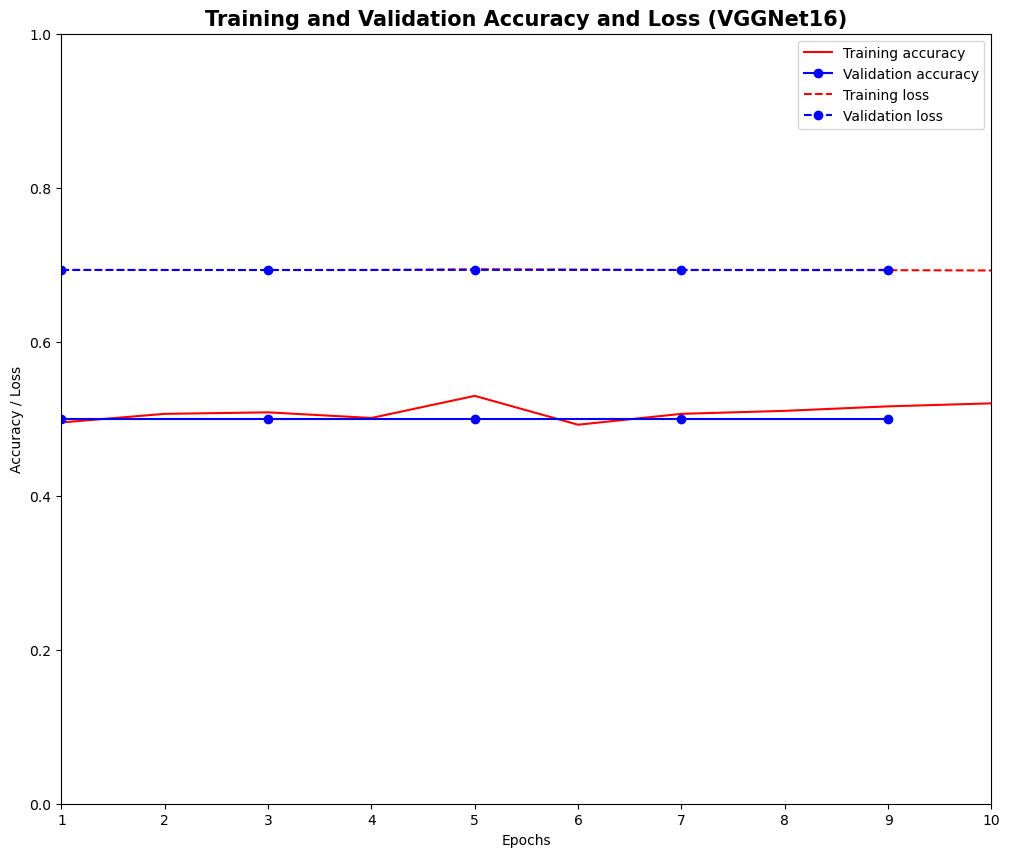

In [14]:
# 학습 결과 시각화
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))
num_epochs = 10
# 에포크 범위 설정
plt.figure(figsize=(12,10))
epochs = range(1, num_epochs + 1)  # x축을 1부터 num_epochs까지 설정
# 정확도 시각화
plt.plot(epochs, acc[:num_epochs], "r", label="Training accuracy")
plt.plot(
    [i for i in range(1, num_epochs + 1) if i % 2 == 1],  # x축도 홀수 에포크
    val_acc,  # y축: 검증 정확도
    "b",
    label="Validation accuracy",
    marker='o'
)
# 손실 시각화
plt.plot(epochs, loss[:num_epochs], "r--", label="Training loss")
# Validation loss: 홀수 에포크에서만 표시
plt.plot(
    [i for i in range(1, num_epochs + 1) if i % 2 == 1],  # x축도 홀수 에포크
    val_loss,  # y축: 검증 손실
    "b--",
    label="Validation loss",
    marker='o'
)
# 그래프 제목 및 레이블 설정
plt.title("Training and Validation Accuracy and Loss (VGGNet16)", fontsize='15', fontweight='bold')
plt.xlabel("Epochs", fontsize='10')
plt.ylabel("Accuracy / Loss", fontsize='10')
plt.legend()
# x축 범위 설정
plt.xlim(1, num_epochs)  # x축 범위를 1에서 num_epochs까지 설정
plt.ylim(0,1)
# 그래프 표시
plt.show()

In [16]:
# 모델 저장
model.save("VGGNet16_수정.keras")